In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
#from gurobipy import GRB

In [2]:
#os.chdir(os.getcwd()+'/outputs/strategic_decisions')
os.chdir(os.getcwd()+'/outputs/ordering_plans')

In [3]:
I_set = 4
K_set = 1
T_set = 12

I_K_dict = {1: [1,2,3,4]}

model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K_set+1))
model.I = Set(initialize = range(1,I_set+1))
model.T = Set(initialize = range(1,T_set+1))
model.T_0 = Set(initialize = range(0,T_set+1))
model.I_K = Set(model.K)
for k in model.K:
    for i in range(0,len(I_K_dict[k])):
        model.I_K[k].add(I_K_dict[k][i])

In [4]:
###health care commodity metric parameters####
#criticality score
r_k_dict = {
    1 : 10
}

#suitability score (only specified for suitable items)
q_k_i_dict = {
    tuple([1,1]):0,
    tuple([1,2]):1,
    tuple([1,3]):2,
    tuple([1,4]):3
}

def rank_score_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_score_initialize)

def criticality_discounting_metric_initialize(model, k, t):
    tau_k_t_temp = (model.r_k[k])**(T_set+1-t)
    
    return(tau_k_t_temp)

model.tau_k_t = Param(model.K, model.T, initialize = criticality_discounting_metric_initialize)

def suitability_score_initialize(model, k, i):
    if (i in model.I_K[k]):
        return(q_k_i_dict.get(tuple([k,i])))
    else:
        return(None)

model.q_k_i = Param(model.K, model.I, initialize = suitability_score_initialize)

def suitability_metric_initialize(model, k, i):
    if (i in model.I_K[k]):
        #return((1/model.r_k[k])**(model.q_k_i[k,i]))
        return(1/(11-model.q_k_i[k,i]))
    else:
        return(None)
    
model.pi_k_i = Param(model.K, model.I, initialize = suitability_metric_initialize)

In [5]:
#######warehouse capacity parameters#######

#size
s_i_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

#total warehouse capacity
h = 100000

def item_size_param_initialize(model, i):
    return(s_i_dict.get(i))

model.s_i = Param(model.I, initialize = item_size_param_initialize)

#model.s_k.pprint()

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

In [6]:
#######budget parameters########

#cost
c_i_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

#budget
b = 10000000000000

def cost_param_initialize(model, i):
    return(c_i_dict.get(1))

model.c_i = Param(model.I, initialize = cost_param_initialize)

#model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

In [7]:
########inventory availability parameters##########
#starting inventory
z_i_init_dict = {
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 0
}

def beg_inv_param_initialize(model, i):
    return(z_i_init_dict.get(i))

model.z_i_init = Param(model.I, initialize = beg_inv_param_initialize)

In [8]:
#######Supply parameters########
#incoming orders
o_i_t_init_dict = {}


for i in range(1,I_set+1):
    for t in range(1,T_set+1):
        if t <= 2:
            o_i_t_init_dict[tuple([i,t])] = 0 #20000/4 #5000
        else:
            o_i_t_init_dict[tuple([i,t])] = 0
            
            
            
#lead times
lead_time_dictionary_supplier_SKU = {1: [3,4,4], #min, max, likely, a,b,c
                     2: [3,4,4], 
                     3: [1,2,3],
                     4: [0,1,0]}

def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

f_i_l_dict = {}
for i in model.I:
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in model.T_0:
        f_i_l_dict[tuple([i,t])] = lead_time_dist_array[t]
        

#supply capacities
cap_dictionary_supplier_SKU = {1: np.repeat([2000,3000], [1,T_set-1]), #min, max, likely, a,b,c
                     2: np.repeat([2500,4000], [1,T_set-1]), 
                     3: [2500]*T_set,
                     4: [20000]*T_set}

cap_dictionary_supplier_SKU_t = {}

for i in model.I:
    for t in model.T:
        cap_dictionary_supplier_SKU_t[tuple([i,t])] = cap_dictionary_supplier_SKU[i][t-1]


#supplier-SKU names
names_supplier_SKU = ['Supplier 1 - SKU: N95-MG', 'Supplier 1 - SKU: N95-N', 
 'Supplier 2 - SKU: SUR-MG', 'Supplier 2 - SKU: SUR-N']

def incoming_orders_initialize(model, i, t):
    return(o_i_t_init_dict.get(tuple([i,t])))

model.o_i_t_init = Param(model.I, model.T, initialize = incoming_orders_initialize)

#model.o_k_i_t.pprint()

def delay_dist_param_initialize(model, i, t):
    return(f_i_l_dict.get(tuple([i,t])))

model.f_i_l = Param(model.I, model.T_0, 
                          initialize = delay_dist_param_initialize)

def supplier_cap_param_initialize(model, i, t):
    return(cap_dictionary_supplier_SKU_t[i,t])

model.cap_i_t = Param(model.I, model.T, initialize = supplier_cap_param_initialize)

#model.cap_k_i_t.pprint()

In [9]:
f_i_l_dict = {}
i = 1
#for i in model.I:
lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                     lead_time_dictionary_supplier_SKU.get(i)[1],
                                     lead_time_dictionary_supplier_SKU.get(i)[2])

print(lead_time_dist_array)
#for t in model.T_0:
#    f_i_l_dict[tuple([i,t])] = lead_time_dist_array[t]

[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]


In [10]:
lead_time_dictionary_supplier_SKU.get(i)

[3, 4, 4]

In [11]:
f_i_l_dict = {}
i = 1
#for i in model.I:
lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                     lead_time_dictionary_supplier_SKU.get(i)[1],
                                     lead_time_dictionary_supplier_SKU.get(i)[2])

In [12]:
model.T_0.pprint()

T_0 : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   13 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [13]:
model.I.pprint()

I : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    4 : {1, 2, 3, 4}


In [14]:
######demand parameters#########

#unfulfilled demand
n_k_init_dict = {
    1 : 0
}

#demand reliability level
epsilon = 0.95

#projected incoming demand
base_demand_k = {1: [8000, 16000, 10000]}

#used in this example to adjust demand RV over time
dynamic_adj_dem_t = {1: [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85, .8, .8]}

def triangular_dist_demand(epsilon, k, t):
    base_demand_ktemp = base_demand_k[k]
    adjust_demand_temp = dynamic_adj_dem_t[k][t-1]
    a = base_demand_ktemp[0]*adjust_demand_temp
    b = base_demand_ktemp[1]*adjust_demand_temp
    c = base_demand_ktemp[2]*adjust_demand_temp

    if epsilon <= (c-a)/(b-a):
        return((a+((((epsilon)*(b-a)*(c-a)))**(1/2))))
    else:
        return((b-(((1-epsilon)*(b-a)*(b-c))**(1/2))))
                

def unfulfilled_demand_param_initialize(model, k):
    return(n_k_init_dict.get(k))

model.n_k_init = Param(model.K, initialize = unfulfilled_demand_param_initialize)

#model.n_k_intialize.pprint()

#assume preparing for one sd above the mean
def demand_param_initialize(model, k, t):
    temp = triangular_dist_demand(epsilon, k,t)
    return(temp)

model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

In [15]:
####initialize variables####
model.x_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_i_t = Var(model.I, model.T, within = NonNegativeReals)
model.n_k_t = Var(model.K, model.T, within = NonNegativeReals)
model.m_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)

In [16]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.pi_k_i[k,i]*sum(model.tau_k_t[k,t]*model.m_k_i_t[k,i,t] 
                                                      for t in model.T) 
                                 for i in model.I_K[k] for k in model.K)),
                            sense = maximize)

In [17]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.n_k_t[k,1] == model.n_k_init[k])

model.initalize_unsatisfied_demand_constraint= \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

In [18]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
    if (t == 1):
        #return(None)
        return(sum(model.m_k_i_t[k,i,t] for i in model.I_K[k]) <= model.n_k_t[k,t] + model.d_k_t[k,t])
    else:
        #return(None)
        return(model.n_k_t[k,t] == model.n_k_t[k,t-1] + model.d_k_t[k,t] \
               - sum(model.m_k_i_t[k,i,t] for i in model.I_K[k]))

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

In [19]:
def supplier_constraint_initialize(model, i, t):
    return(model.x_i_t[i,t] <= model.cap_i_t[i,t])

model.supplier_constraint = \
Constraint( model.I, model.T, rule = supplier_constraint_initialize)

In [20]:
def incoming_orders_constraint_initialize(model, i, t):
    return(model.y_i_t[i,t] - 
           sum(model.f_i_l[i, t-t_ordered_time]*model.x_i_t[i,t_ordered_time] 
               for t_ordered_time in range(1,t+1)) - model.o_i_t_init[i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

In [21]:
def beggining_inventory_constraint_initialize(model, i):
    return(model.z_i_t[i,1] == model.z_i_init[i])
    
model.beggining_inventory_constraint = Constraint(model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

In [22]:
def calculate_available_inventory_constraint_initialize(model, i, t):
    if (t > 1):
        return(model.z_i_t[i,t] == model.z_i_t[i,t-1] + model.y_i_t[i,t-1] - \
               sum(model.m_k_i_t[k,i,t-1] for k in model.K))
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

In [23]:
model.n_k_t.pprint()

n_k_t : Size=12, Index=n_k_t_index
    Key     : Lower : Value : Upper : Fixed : Stale : Domain
     (1, 1) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 2) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 3) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 4) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 5) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 6) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 7) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 8) :     0 :  None :  None : False :  True : NonNegativeReals
     (1, 9) :     0 :  None :  None : False :  True : NonNegativeReals
    (1, 10) :     0 :  None :  None : False :  True : NonNegativeReals
    (1, 11) :     0 :  None :  None : False :  True : NonNegativeReals
    (1, 12) :     0 :  None :  None : False :  True : NonNegativeReals


In [24]:
def cannot_fulfill_more_than_available_constraint_initialize(model, i, t):
    return(sum(model.m_k_i_t[k,i,t] for k in model.K) - model.z_i_t[i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [25]:
def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_i[i]*model.z_i_t[i,t] for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

In [26]:
model.warehouse_capacity_constraint.pprint()

warehouse_capacity_constraint : Size=12, Index=T, Active=True
    Key : Lower : Body                                                  : Upper    : Active
      1 :  -Inf :     z_i_t[1,1] + z_i_t[2,1] + z_i_t[3,1] + z_i_t[4,1] : 100000.0 :   True
      2 :  -Inf :     z_i_t[1,2] + z_i_t[2,2] + z_i_t[3,2] + z_i_t[4,2] : 100000.0 :   True
      3 :  -Inf :     z_i_t[1,3] + z_i_t[2,3] + z_i_t[3,3] + z_i_t[4,3] : 100000.0 :   True
      4 :  -Inf :     z_i_t[1,4] + z_i_t[2,4] + z_i_t[3,4] + z_i_t[4,4] : 100000.0 :   True
      5 :  -Inf :     z_i_t[1,5] + z_i_t[2,5] + z_i_t[3,5] + z_i_t[4,5] : 100000.0 :   True
      6 :  -Inf :     z_i_t[1,6] + z_i_t[2,6] + z_i_t[3,6] + z_i_t[4,6] : 100000.0 :   True
      7 :  -Inf :     z_i_t[1,7] + z_i_t[2,7] + z_i_t[3,7] + z_i_t[4,7] : 100000.0 :   True
      8 :  -Inf :     z_i_t[1,8] + z_i_t[2,8] + z_i_t[3,8] + z_i_t[4,8] : 100000.0 :   True
      9 :  -Inf :     z_i_t[1,9] + z_i_t[2,9] + z_i_t[3,9] + z_i_t[4,9] : 100000.0 :   True
     10 :  -Inf : 

In [27]:
def budget_constraint_initialize(model):
    return(sum(model.c_i[i]*model.x_i_t[i,t] 
               for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [28]:
opt = SolverFactory('glpk')
opt.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 1123268887932.33, 'Upper bound': 1123268887932.33, 'Number of objectives': 1, 'Number of constraints': 219, 'Number of variables': 205, 'Number of nonzeros': 619, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.017567873001098633}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [29]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[1])

In [30]:
model.cap_i_t.pprint()

cap_i_t : Size=48, Index=cap_i_t_index, Domain=Any, Default=None, Mutable=False
    Key     : Value
     (1, 1) :  2000
     (1, 2) :  3000
     (1, 3) :  3000
     (1, 4) :  3000
     (1, 5) :  3000
     (1, 6) :  3000
     (1, 7) :  3000
     (1, 8) :  3000
     (1, 9) :  3000
    (1, 10) :  3000
    (1, 11) :  3000
    (1, 12) :  3000
     (2, 1) :  2500
     (2, 2) :  4000
     (2, 3) :  4000
     (2, 4) :  4000
     (2, 5) :  4000
     (2, 6) :  4000
     (2, 7) :  4000
     (2, 8) :  4000
     (2, 9) :  4000
    (2, 10) :  4000
    (2, 11) :  4000
    (2, 12) :  4000
     (3, 1) :  2500
     (3, 2) :  2500
     (3, 3) :  2500
     (3, 4) :  2500
     (3, 5) :  2500
     (3, 6) :  2500
     (3, 7) :  2500
     (3, 8) :  2500
     (3, 9) :  2500
    (3, 10) :  2500
    (3, 11) :  2500
    (3, 12) :  2500
     (4, 1) : 20000
     (4, 2) : 20000
     (4, 3) : 20000
     (4, 4) : 20000
     (4, 5) : 20000
     (4, 6) : 20000
     (4, 7) : 20000
     (4, 8) : 20000
     (4, 9) : 20000


In [31]:
ordered_df

,sets,units_to_order,supplier,time_interval
0,"(1, 1)",2000.000000,1,1
1,"(1, 2)",3000.000000,1,2
2,"(1, 3)",3000.000000,1,3
3,"(1, 4)",3000.000000,1,4
4,"(1, 5)",3000.000000,1,5
5,"(1, 6)",3000.000000,1,6
6,"(1, 7)",3000.000000,1,7
7,"(1, 8)",3000.000000,1,8
8,"(1, 9)",0.000000,1,9
9,"(1, 10)",0.000000,1,10


In [32]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[1])

In [33]:
recieved_df

,sets,expected_units_recieved,supplier,time_interval
0,"(1, 1)",0.000000,1,1
1,"(1, 2)",0.000000,1,2
2,"(1, 3)",0.000000,1,3
3,"(1, 4)",1000.000000,1,4
4,"(1, 5)",2500.000000,1,5
5,"(1, 6)",3000.000000,1,6
6,"(1, 7)",3000.000000,1,7
7,"(1, 8)",3000.000000,1,8
8,"(1, 9)",3000.000000,1,9
9,"(1, 10)",3000.000000,1,10


In [34]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
#fulfilled_df['delay'] = fulfilled_df['time_interval'] - fulfilled_df['time_interval_req']

In [35]:
fulfilled_df

,sets,units_fulfilled,item_type,supplier,time_interval
0,"(1, 1, 1)",0.000000,1,1,1
1,"(1, 1, 2)",0.000000,1,1,2
2,"(1, 1, 3)",0.000000,1,1,3
3,"(1, 1, 4)",0.000000,1,1,4
4,"(1, 1, 5)",1000.000000,1,1,5
5,"(1, 1, 6)",2500.000000,1,1,6
6,"(1, 1, 7)",3000.000000,1,1,7
7,"(1, 1, 8)",3000.000000,1,1,8
8,"(1, 1, 9)",3000.000000,1,1,9
9,"(1, 1, 10)",3000.000000,1,1,10


In [36]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[1])

In [37]:
available_df

,sets,units_available,supplier,time_interval
0,"(1, 1)",0.000000,1,1
1,"(1, 2)",0.000000,1,2
2,"(1, 3)",0.000000,1,3
3,"(1, 4)",0.000000,1,4
4,"(1, 5)",1000.000000,1,5
5,"(1, 6)",2500.000000,1,6
6,"(1, 7)",3000.000000,1,7
7,"(1, 8)",3000.000000,1,8
8,"(1, 9)",3000.000000,1,9
9,"(1, 10)",3000.000000,1,10


In [38]:
model.m_k_i_t.pprint()

m_k_i_t : Size=48, Index=m_k_i_t_index
    Key        : Lower : Value            : Upper : Fixed : Stale : Domain
     (1, 1, 1) :     0 :              0.0 :  None : False : False : NonNegativeReals
     (1, 1, 2) :     0 :              0.0 :  None : False : False : NonNegativeReals
     (1, 1, 3) :     0 :              0.0 :  None : False : False : NonNegativeReals
     (1, 1, 4) :     0 :              0.0 :  None : False : False : NonNegativeReals
     (1, 1, 5) :     0 :           1000.0 :  None : False : False : NonNegativeReals
     (1, 1, 6) :     0 :           2500.0 :  None : False : False : NonNegativeReals
     (1, 1, 7) :     0 :           3000.0 :  None : False : False : NonNegativeReals
     (1, 1, 8) :     0 :           3000.0 :  None : False : False : NonNegativeReals
     (1, 1, 9) :     0 :           3000.0 :  None : False : False : NonNegativeReals
    (1, 1, 10) :     0 :           3000.0 :  None : False : False : NonNegativeReals
    (1, 1, 11) :     0 :           3

In [39]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [40]:
unsatisfied_df

,sets,units_unsatisfied,item_type,time_interval
0,"(1, 1)",0.000000,1,1
1,"(1, 2)",0.000000,1,2
2,"(1, 3)",0.000000,1,3
3,"(1, 4)",0.000000,1,4
4,"(1, 5)",0.000000,1,5
5,"(1, 6)",0.000000,1,6
6,"(1, 7)",0.000000,1,7
7,"(1, 8)",0.000000,1,8
8,"(1, 9)",0.000000,1,9
9,"(1, 10)",0.000000,1,10


In [41]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [42]:
demand_df

,sets,demand_in_units,item_type,time_interval
0,"(1, 1)",7225.403331,1,1
1,"(1, 2)",7947.943664,1,2
2,"(1, 3)",8670.483997,1,3
3,"(1, 4)",14450.806662,1,4
4,"(1, 5)",15895.887328,1,5
5,"(1, 6)",21676.209992,1,6
6,"(1, 7)",23121.290658,1,7
7,"(1, 8)",17340.967994,1,8
8,"(1, 9)",15895.887328,1,9
9,"(1, 10)",12283.185662,1,10


In [43]:
ordered_and_recieved_df = ordered_df[['supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [44]:
#os.chdir(results_dir)
#ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

#recieved_df.to_csv('recieving_schedule.csv')
#ordered_df.to_csv('ordering_schedule.csv')

In [45]:
#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1].groupby(['time_interval'])['units_unsatisfied']\
.sum().reset_index()
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df.groupby(['time_interval'])["units_available"]\
.sum().reset_index()

In [46]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

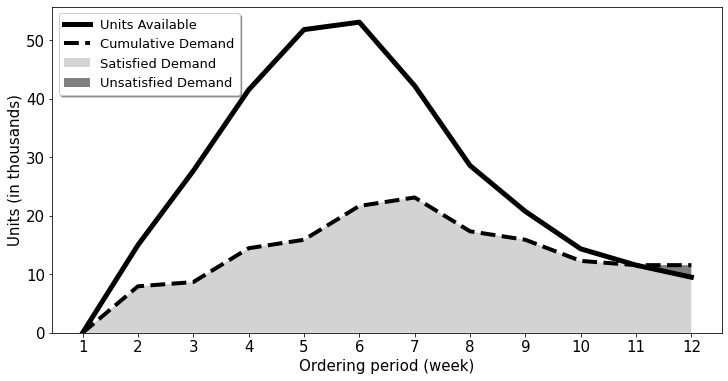

In [47]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

fig2, ax2 = plot.subplots(figsize=(12,6))

ax2.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available']/1000, 
          label='Units Available',
          color ="black",
         linewidth=5) 

#ax2.plot(demand_df['time_interval'], 
#         (demand_df['demand_in_units'])/1000 , 
#         label='incoming demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
#         linewidth=10,
#         color = "lime")

ax2.plot(demand_df['time_interval'], 
         (temp_all['units_unsatisfied']+temp_all['units_fulfilled'])/1000, 
         label='Cumulative Demand',
         linewidth=4,
         color = "black",
         linestyle='dashed')

# Your x and y axis
x=range(1,T_set+1)
y=[temp_all['units_fulfilled']/1000, temp_all['units_unsatisfied']/1000]
 
# use a known color palette (see..)
pal = ["#D3D3D3", "#808080"]
plot.stackplot(x,y, labels=['Satisfied Demand', 'Unsatisfied Demand'], colors=pal)
plot.legend(loc='upper right')
plot.xticks(fontsize= 15)
plot.yticks(fontsize= 15)
ax2.xaxis.set_ticks(np.arange(1, T_set+1, 1))
#ax2.yaxis.set_ticks(np.arange(0, 160, 20))

ax2.set_xlabel('Ordering period (week)', fontsize=15)
ax2.set_ylabel('Units (in thousands)', fontsize=15)
#ax2.set_title('Option 1: Budget of \$700,000 and renew lease', fontsize = 15)
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks (k=1) \n summed over all suppliers (i) at each Time Interval (t)\
#\n medium supplier risk, medium demand reliability', fontsize='xx-large')
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks during each Time Interval\
#\n Assuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax2.legend(loc='upper left', shadow=True, fontsize=13)


plot.savefig('12000K_overtime.jpg')
#plot.savefig('900K_overtime.jpg')

In [48]:
os.getcwd()

'/Users/chelseagreene/github/epi_supplychain_optimization/inventory_management/model/publication/journal_of_humanitarian_log_and_scm/outputs/ordering_plans'

In [49]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1].groupby(['time_interval'])['units_unsatisfied']\
.sum().reset_index()
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df.groupby(['time_interval'])["units_available"]\
.sum().reset_index()
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')
temp_all['percent_unsatisfied'] = temp_all['units_unsatisfied']/(temp_all['units_fulfilled'] + temp_all['units_unsatisfied'])
temp_all['stacked'] = temp_all['units_fulfilled'] + temp_all['units_unsatisfied']

In [50]:
units = []
name = []
time_interval = []

In [51]:
for i in fulfilled_df.index:
    units.append(fulfilled_df['units_fulfilled'].iloc[i])
    time_interval.append(fulfilled_df['time_interval'].iloc[i])
    if (fulfilled_df['supplier'].iloc[i] == 1):
        name.append('SKU: N95-MG')
    elif (fulfilled_df['supplier'].iloc[i] == 2):
        name.append('SKU: N95-N')
    elif (fulfilled_df['supplier'].iloc[i] == 3):
        name.append('SKU: SUR-MG')
    else:
        name.append('SKU: SUR-N')

        
for i in unsatisfied_df.index:
    units.append(unsatisfied_df['units_unsatisfied'].iloc[i])
    time_interval.append(unsatisfied_df['time_interval'].iloc[i])
    name.append('unsatisfied_demand')

In [52]:
stacked_temp = pd.DataFrame(list(zip(name, time_interval, units)), 
                    columns =['name', 'time_interval', 'units']).groupby(['time_interval', 'name']).sum()\
.reset_index()

In [53]:
stacked_temp['units'] = stacked_temp['units']/1000

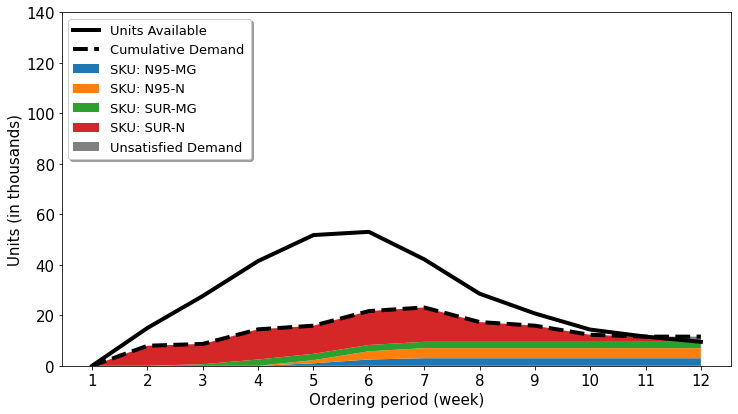

In [54]:
fig2, ax3 = plot.subplots(figsize=(12,6.5))

ax3.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available']/1000,  
          label='Units Available',
          color ="black",
         linewidth=4) 

#ax3.plot(demand_df['time_interval'], 
#         (demand_df['demand_in_units'])/1000 , 
#         label='incoming demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
#         linewidth=5,
#         color = "#fb169b")

ax3.plot(demand_df['time_interval'], 
         (temp_all['units_fulfilled']+temp_all['units_unsatisfied'])/1000, 
         label='Cumulative Demand',
         linewidth=4,
         color = "black",
         linestyle='dashed')

# Your x and y axis
x=range(1,T_set+1)
y=[stacked_temp[stacked_temp['name'] == 'SKU: N95-MG']['units'], stacked_temp[stacked_temp['name'] == 'SKU: N95-N']['units'],
  stacked_temp[stacked_temp['name'] == 'SKU: SUR-MG']['units'], stacked_temp[stacked_temp['name'] == 'SKU: SUR-N']['units'],
  stacked_temp[stacked_temp['name'] == 'unsatisfied_demand']['units']]
 
# use a known color palette (see..)
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
#ax3.stackplot(x,y)#, labels=['High Capacity R US (Surgical Masks)', 'Affordable PPE (Cloth Masks)', 'Speedy Industries (Surgical Masks)', 
                            #'High Quality Inc. (N95 Masks)', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)
ax3.stackplot(x,y, labels=['SKU: N95-MG', 'SKU: N95-N', 'SKU: SUR-MG', 
                            'SKU: SUR-N', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)

plot.xticks(fontsize= 15)
plot.yticks(fontsize= 15)

ax3.xaxis.set_ticks(np.arange(1, T_set+1, 1))
ax3.yaxis.set_ticks(np.arange(0, 160, 20))
#ax3.yaxis.set_ticks(np.arange(0, 100000, 10000))


ax3.set_xlabel('Ordering period (week)', fontsize=15)
ax3.set_ylabel('Units (in thousands)', fontsize=15)
#ax3.set_title('Option 1: Budget of \$700,000 and renew lease \n by supplier-SKU identified for fulfilling orders', fontsize = 15)
#ax3.set_title('Available, Unsatisfied, and Satisfied Units of Masks from each Supplier during each Time Interval\
#\nAssuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax3.legend(loc='upper left', shadow=True, fontsize=13)
#plot.savefig('1200K_overtime_supplier.jpg')
plot.savefig('900K_overtime_supplier.jpg')

In [ ]:
I_set = 4

In [ ]:
### ordering and recieving picture
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
text_color_dict_all = {}
G_dict_all = {}
edge_labels_dict_all = {}

In [ ]:
for i in range(1,I_set+1):
    #G=nx.Graph()
    G = nx.DiGraph()
    label_dict = {}
    color_map = []
    text_color_map = []
    
    global ordered_df
    global recieved_df
    
    time_coordinates = range(1,T_set+1)
    ordered_amount_coordinates = np.array(ordered_df[(ordered_df['supplier'] == i)]['units_to_order'])
    recieved_amount_coordinates = np.array(recieved_df[(recieved_df['supplier'] == i)]['expected_units_recieved'])

    for t in range(T_set):
        ordered_amount = ordered_amount_coordinates[t]
        recieved_amount = recieved_amount_coordinates[t]

        if (ordered_amount > 0):
            name = 'ordered at ' + str(t+1) + ' from supplier ' + str(i)
            G.add_node(name, pos = (t+1,1))
            label_dict[name] = format(int(round(ordered_amount,0)), ',')
            color_map.append('white')
            text_color_map.append('white')

        if (recieved_amount > 0):
            name = 'recieved at ' + str(t+1)+ ' from supplier ' + str(i)
            G.add_node(name, pos = (t+1,2))
            label_dict[name] = format(int(round(recieved_amount,0)), ',')
            color_map.append('lightgray')
            text_color_map.append('black')

    pos=nx.get_node_attributes(G,'pos')
    label_dict_all['supplier' + str(i)] = label_dict
    color_dict_all['supplier' + str(i)] = color_map
    text_color_dict_all['supplier' + str(i)] = text_color_map
    pos_dict_all['supplier' + str(i)] = pos
    G_dict_all['supplier' + str(i)] = G
    
    
    ordered_df_filtered = ordered_df[(ordered_df['supplier'] == i) 
                                     & (ordered_df['units_to_order'] > 0)]
    
    for t_tilde in ordered_df_filtered['time_interval']:
        for t in range(T_set+1):
            if t_tilde <= t:
                prob = f_i_l_dict.get(tuple([i,t-t_tilde]))
                if (prob > 0):
                    temp = ordered_df_filtered[ordered_df_filtered['time_interval'] == t_tilde]
                    edge_start = 'ordered at ' + str(t_tilde) + ' from supplier ' + str(i)
                    edge_end = 'recieved at ' + str(t)+ ' from supplier ' + str(i)
                    amount = format(round((prob*temp['units_to_order'].values[0]),0).astype(int), ',')
                    G.add_edge(edge_start, edge_end, label=amount)

    edge_labels_dict_all['supplier' + str(i)]  = nx.get_edge_attributes(G, 'label')

In [ ]:
ordered_df_filtered = ordered_df[(ordered_df['supplier'] == 2) 
                                     & (ordered_df['units_to_order'] > 0)]

In [ ]:
for k in edge_labels_dict_all.get('supplier' + str(i)).keys():
    temp1 = edge_labels_dict_all.get('supplier' + str(i)).get(k)
    temp2 = {k:temp1}

#os.chdir('/Users/chelseagreene/github/epi_supplychain_optimization/inventory_management/model/publication/Final/outputs/3_2_2_ordering_plans')

In [ ]:
names_supplier_SKU=['Supplier 1 - SKU: N95-MG \nMedical-grade N-95 masks', 'Supplier 1 - SKU: N95-MG\nNon-medical-grade N-95 masks',
                  'Supplier 2 - SKU: SUR-MG\nMedical-grade surgical masks', 'Supplier 2 - SKU: SUR-Non\nNon-medical-grade surgical masks']

In [ ]:
color_dict_all.get('supplier' + str(i)) 

In [ ]:
for i in range(1, I_set+1):
    fig, ax = plot.subplots(figsize=(10,6))
    
          
    nx.draw(G_dict_all.get('supplier' + str(i)),
            pos_dict_all.get('supplier' + str(i)), 
            labels=label_dict_all.get('supplier' + str(i)),
            node_size=2000, font_size=13,
            edgecolors= 'black', 
            font_color = 'black',
            with_labels = True, 
            node_color=color_dict_all.get('supplier' + str(i)), 
            ax = ax)#,
            #font_weight = 'bold')
    
    label_pos_temp = .7
    
    #nx.set_edgecolor('r')
    
    for k in edge_labels_dict_all.get('supplier' + str(i)).keys():
        temp1 = edge_labels_dict_all.get('supplier' + str(i)).get(k)
        temp2 = {k:temp1}
        
        if(label_pos_temp == .7):
            label_pos_temp = .3
        else:
            label_pos_temp = .7
            
        nx.draw_networkx_edge_labels(G_dict_all.get('supplier' + str(i)), 
                                     pos_dict_all.get('supplier' + str(i)), 
                                     temp2,
                                     label_pos = label_pos_temp,
                                    #arrows = True,
                                    font_size = 11)
        
        #nx.draw_networkx_edge_labels(G_dict_all.get('supplier' + str(i)), pos_dict_all.get('supplier' + str(i)), 
        #                             edge_labels_dict_all.get('supplier' + str(i)),
        #                            label_pos = pos_dict_all_labels)
    
    
    ax.set_xlabel('Ordering period (week)',
                 fontsize = 15)
    ax.set_ylabel('Place order             Recieve order \n                             (Projected)',
                 fontsize = 15)
    ax.set(ylim=(.5, 2.5))
    ax.xaxis.set_ticks(np.arange(1, T_set+1, 1))
    #ax.set_title('Time Interval Order is Placed and Recieved \n for Supplier '+ str(i)+' for Item 1',
    #            fontsize = 20)
    #ax.set_title('Ordering schedule for ' + names_supplier_SKU[i-1],# + ' with reliability level '+ "{:.0%}".format(reliability_level),
    #            fontsize='x-large')
    ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    limits=plot.axis('on')
    
    #if i == 1:
    #    plot.savefig('S1_MG.jpg')
    #if i == 2:
    #    plot.savefig('S1_Non.jpg')
    #if i == 3:
    #    plot.savefig('S2_MG.jpg')
    #if i == 4:
    #    plot.savefig('S2_Non.jpg')

In [ ]:
demand_df

In [ ]:
fulfilled_df